# LinkCell

Many of the most powerful analyses of particle simulations involve some characterization of the local environments of particles.
Whether the analyses involve finding clusters, identifying interfaces, computing order parameters, or something else entirely, they always require finding particles in proximity to others so that properties of the local environment can be computed.
The `freud.locality.NeighborList` and `freud.locality.LinkCell` classes are the fundamental building blocks for this type of calculation.
The `NeighborList` class is essentially a container for particle pairs that are determined to be adjacent to one another.
The `LinkCell` class implements the standard linked-list cell algorithm, in which a [cell list](https://en.wikipedia.org/wiki/Cell_lists) is computed using [linked lists](https://en.wikipedia.org/wiki/Linked_list) to store the particles in each cell.
In this notebook, we provide a brief demonstration of how this data structure works and how it is used throughout freud.

We begin by demonstrating how a cell list works, which is essentially by dividing space into fixed width cells.

In [1]:
from __future__ import division
import freud
import numpy as np
from matplotlib import pyplot as plt
import timeit

# place particles 0 and 1 in cell 0
# place particle 2 in cell 1
# place particles 3,4,5 in cell 3
# and no particles in cells 4,5,6,7
particles = np.array([[-0.5, -0.5, 0],
                   [-0.6, -0.6, 0],
                   [0.5, -0.5, 0],
                   [-0.5, 0.5, 0],
                   [-0.6, 0.6, 0],
                   [-0.7, 0.7, 0]], dtype='float32')


L = 2  # The box size
r_max = 1  # The cell width, and the nearest neighbor distance
box = freud.box.Box.square(L)
lc = freud.locality.LinkCell(box, r_max)
lc.compute(box, particles)

for c in range(0, lc.num_cells):
    print("The following particles are in cell {}: {}".format(c, ', '.join([str(x) for x in lc.itercell(c)])))

The following particles are in cell 0: 0, 1
The following particles are in cell 1: 2
The following particles are in cell 2: 3, 4, 5
The following particles are in cell 3: 


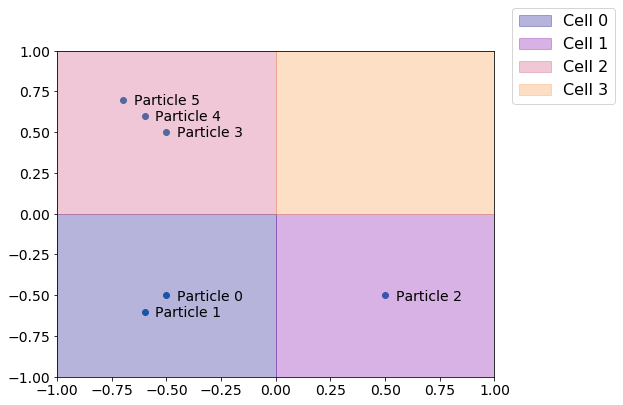

In [2]:
from matplotlib import patches
from matplotlib import cm
cmap = cm.get_cmap('plasma')
colors = [cmap(i/lc.num_cells) for i in range(lc.num_cells)]

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(particles[:, 0], particles[:, 1])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
corners = [(-1, -1), (0, -1), (-1, 0), (0, 0)]
handles = []
labels = []
for i, corner in enumerate(corners):
    p = patches.Rectangle(corner, 1, 1, color=colors[i], alpha=0.3)
    ax.add_patch(p)
    handles.append(p)
    labels.append("Cell {}".format(i))
ax.tick_params(axis='both', which='both', labelsize=14)
fig.legend(handles, labels, fontsize=16)
fig.subplots_adjust(right=0.8)
for i, p in enumerate(particles):
    ax.text(p[0]+0.05, p[1]-0.03, "Particle {}".format(i), fontsize=14)

The principle behind a cell list is that depending on how close particles have to be to be considered neighbors, we can construct a cell list of an appropriate width such that a given particle's neighbors can always be found by only looking in the neighboring cells, saving us the work of checking all the other particles in the system.
We can now extract the NeighborList object computed using this cell list for finding particle neighbors.

In [3]:
nlist = lc.nlist
for i in set(nlist.index_i):
    js = nlist.index_j[nlist.index_i == i]
    print("The particles within a distance 1 of particle {} are: {}".format(
        i, ', '.join([str(j) for j in js])))

The particles within a distance 1 of particle 0 are: 1, 4, 5
The particles within a distance 1 of particle 1 are: 0, 2, 3, 4, 5
The particles within a distance 1 of particle 2 are: 1
The particles within a distance 1 of particle 3 are: 1, 4, 5
The particles within a distance 1 of particle 4 are: 0, 1, 3, 5
The particles within a distance 1 of particle 5 are: 0, 1, 3, 4


Finally, we can easily check this computation manually by just computing particle distances.
Note that we need to be careful to make sure that we properly respect the box periodicity, which means that interparticle distances should be calculated according to the [minimum image convention](https://en.wikipedia.org/wiki/Periodic_boundary_conditions).
In essence, this means that since the box is treated as being infinitely replicated in all directions, we have to ensure that each particle is only interacting with the closest copy of another particle.
We can easily enforce this here by making sure that particle distances are never large than half the box length in any given dimension.

In [4]:
def compute_distances(box, positions):
    """Compute pairwise particle distances, taking into account PBCs.
    
    Args:
        box (:class:`freud.box.Box`): The simulation box the particles live in.
        positions (:class:`np.ndarray`): The particle positions.
    """
    # First we shift all the particles so that the coordinates lie from
    # [0, L] rather than [-L/2, L/2].
    positions[:, 0] = np.mod(positions[:, 0]+box.Lx/2, box.Lx)
    positions[:, 1] = np.mod(positions[:, 1]+box.Ly/2, box.Ly)
    positions[:, 0] = np.mod(positions[:, 0]+box.Lx/2, box.Lx)
    positions[:, 1] = np.mod(positions[:, 1]+box.Ly/2, box.Ly)

    # To apply minimum image convention, we check if the distance is
    # greater than half the box length in either direction, and if it
    # is, we replace it with L-distance instead. We use broadcasting
    # to get all pairwise positions, then modify the pos2 array where
    # the distance is found to be too large for a specific pair.
    pos1, pos2 = np.broadcast_arrays(positions[np.newaxis, :, :], positions[:, np.newaxis, :])
    vectors = pos1 - pos2
    pos2[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(pos2[:, :, 0]),
                                pos2[:, :, 0])
    pos2[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(pos2[:, :, 1]),
                                pos2[:, :, 1])

    distances = np.linalg.norm(pos1 - pos2, axis=-1)
    return distances

In [5]:
pairwise_distances = compute_distances(box, particles)
for i in range(pairwise_distances.shape[0]):
    js = np.where(pairwise_distances[i, :] < r_max)
    print("The particles within a distance 1 of particle {} are: {}".format(
        i, ', '.join([str(j) for j in js[0] if not j==i])))

The particles within a distance 1 of particle 0 are: 1, 4, 5
The particles within a distance 1 of particle 1 are: 0, 2, 3, 4, 5
The particles within a distance 1 of particle 2 are: 1
The particles within a distance 1 of particle 3 are: 1, 4, 5
The particles within a distance 1 of particle 4 are: 0, 1, 3, 5
The particles within a distance 1 of particle 5 are: 0, 1, 3, 4


For larger systems, however, such pairwise calculations would quickly become prohibitively expensive.
The primary benefit of the LinkCell object is that it can dramatically improve this cost.

In [6]:
log_Ns = np.arange(5, 12)
lc_times = []
naive_times = []
for log_N in log_Ns:
    print("Running for log_N = {}".format(log_N))
    particles = np.random.rand(int(2**log_N), 3)*L-L/2
    particles[:, 0] = 0
    lc_times.append(timeit.timeit("lc.compute(box, particles)", number=10, globals=globals()))
    naive_times.append(timeit.timeit("compute_distances(box, particles)", number=10, globals=globals()))

Running for log_N = 5
Running for log_N = 6
Running for log_N = 7
Running for log_N = 8
Running for log_N = 9
Running for log_N = 10
Running for log_N = 11


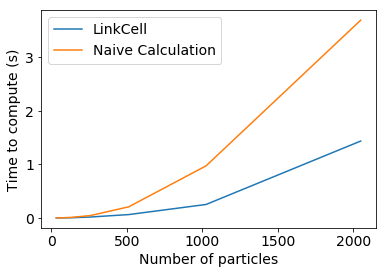

In [7]:
fig, ax = plt.subplots()
ax.plot(2**log_Ns, lc_times, label="LinkCell")
ax.plot(2**log_Ns, naive_times, label="Naive Calculation")
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("Number of particles", fontsize=14)
ax.set_ylabel("Time to compute (s)", fontsize=14);